<center style><h3>Computer Assignment 3</h3></center>
<center style><h4>Naive Bayes Classifier</h4></center>
 <h4 style="text-align:right">
        محمد پویا افشاری - 810198577
</h4>


Project-point: in this project we are going to create a classifier based on Naive Bayes to classify Persian Digits.


Problem definition: In this exercise, you will work with a dataset of Persian handwritten numbers. The dataset contains images of 10 digits from 0 to 9 in Farsi language. There are a total of 102,352 images in this dataset, 6,000 of which are given to you for training.The data set is provided as a list of Python arrays and the label set is provided as a list of numbers from 0 to 9.


### First phase: data review and preprocessing


1. How did you divide the data set into two sets of train and test? Explain the reason for your chosen number for the division ratio

I would use the train_test_split function from the scikit-learn library in Python to divide Dataset into two seperate parts a 70:30 split for the train and test sets respectively, we can use the following code:

The reason for choosing a 90:10 split is that it is a commonly used ratio for training and testing machine learning models. This ratio allows us to have enough data to train the model and also evaluate its performance on a separate test set.


In [379]:
from sklearn.model_selection import train_test_split
import pickle

# Load data and labels
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('label.pkl', 'rb') as f:
    labels = pickle.load(f)


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1, random_state=42)


2. Check an image in the train data set randomly and show (use the matplotlib library), what are the limits of the values of each pixel.

We then displayed the image using the imshow function from matplotlib, and added a colorbar to show the pixel value scale. Finally, we printed the range of pixel values using the min and max functions.
limits of the pixel values depend on the image data type, here pixel values range from 0 to 255.


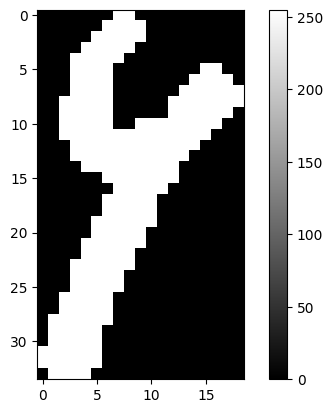

Pixel value range: [0, 255]


In [380]:
import matplotlib.pyplot as plt

# Choose a random image from the train data set
random_index = 3
image = train_data[random_index]

# Show the image and its pixel values
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show()

# Show the range of pixel values
print(f"Pixel value range: [{image.min()}, {image.max()}]")


3. Since the images vary in size, resize the images to 20x20. Also mention the reason for equalizing the size of the images

To resize the images to 20x20, we can use the resize function from the scikit-image library in Python. we can also resize the images using the PIL (Python Imaging Library) module which we used here:

In this example, we use the Image.fromarray function to convert each image to a PIL image object. We then use the resize method of the PIL image object to resize the image to 20x20. Finally, we convert the resized image back to a NumPy array using the np.array function, and append it to the new lists train_data_resized and test_data_resized. I used second method which means I used PIL for resizing. This can be slower than using the resize function from skimage.transform, especially for large datasets.

The reason for equalizing the size of the images is to ensure that all images have the same dimensions, which is required by many machine learning algorithms. This allows us to process the images in a consistent manner, and extract meaningful features that can be used for classification. Additionally, resizing the images to a smaller size can help reduce the computational complexity of the model, which is especially useful when dealing with large datasets. However, it is important to note that resizing the images can also result in some loss of information, so the choice of target size should be made carefully based on the specific requirements of the problem at hand.


In [381]:
from PIL import Image
import numpy as np

# Resize the train images
train_data_resized = []
for image in train_data:
    image_pil = Image.fromarray(image)
    resized_image_pil = image_pil.resize((20, 20))
    resized_image = np.array(resized_image_pil)
    train_data_resized.append(resized_image)

# Resize the test images
test_data_resized = []
for image in test_data:
    image_pil = Image.fromarray(image)
    resized_image_pil = image_pil.resize((20, 20))
    resized_image = np.array(resized_image_pil)
    test_data_resized.append(resized_image)


The fact that `len(train_labels)` is 4200 instead of 6000 means we chose a subset so we adjust the code that chooses one image from each class to use the correct range of indices


In [382]:
print(len(train_labels))


5400


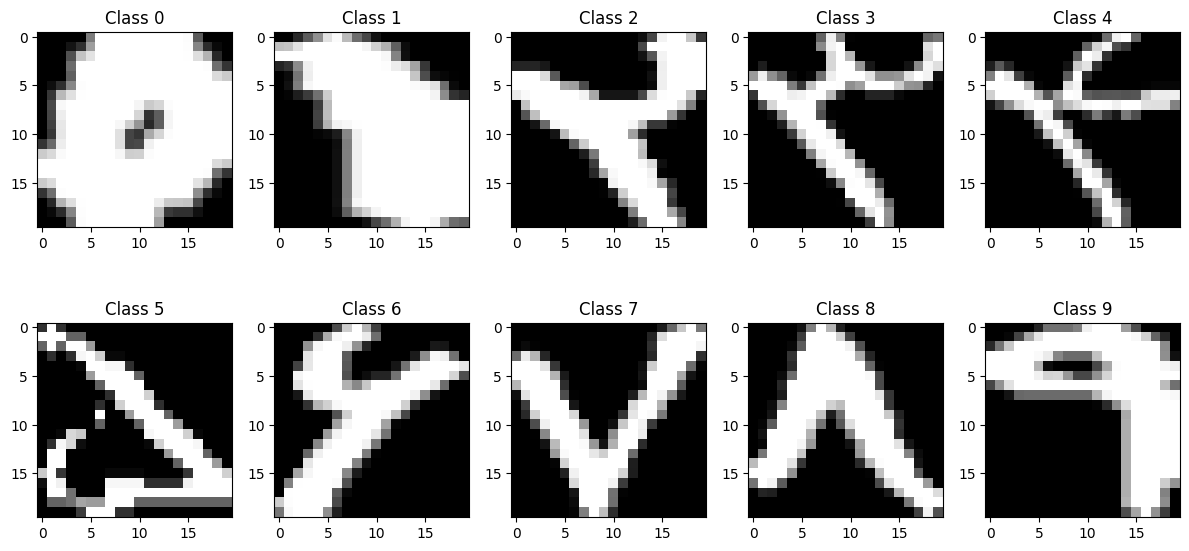

In [383]:
class_indices = [np.where(np.array(train_labels) == i)[0][0]
                 for i in range(10)]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    # Find the index of the first image in the train dataset with label i
    index = np.where(np.array(train_labels) == i)[0][0]

    # Display the image and its label
    image = train_data_resized[index]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Class {i}")
plt.tight_layout()
plt.show()


5. Calculate the number of images in each category for the train and test datasets and draw a bar graph for them?


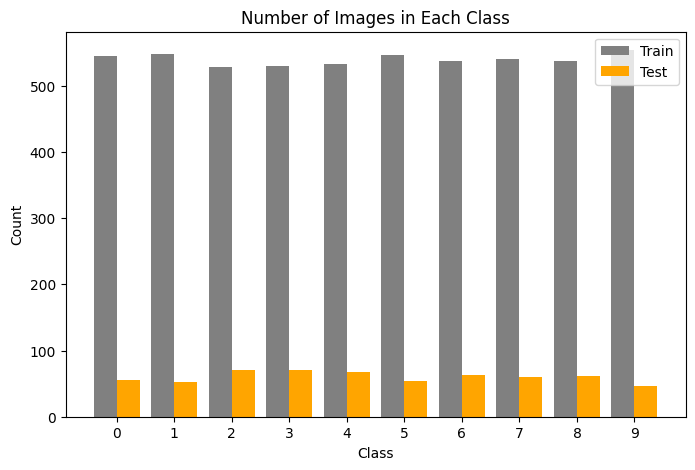

In [384]:
# Count the number of images in each category for the train and test datasets
train_counts = [len(np.where(np.array(train_labels) == i)[0])
                for i in range(10)]
test_counts = [len(np.where(np.array(test_labels) == i)[0]) for i in range(10)]

# Create a bar chart to visualize the counts
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(np.arange(10) - 0.2, train_counts,
       width=0.4, color='gray', label='Train')
ax.bar(np.arange(10) + 0.2, test_counts,
       width=0.4, color='orange', label='Test')
ax.set_xticks(range(10))
ax.set_xticklabels(range(10))
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Number of Images in Each Class')
ax.legend()
plt.show()


6. Scale the amount of data so that each pixel value is between 0 and 1 before giving the information to Naive Bayes Classifier, What can happen if you don't do this?

Scaling the pixel values to be between 0 and 1 is a common pre-processing step for image data. If you don't do this, it can result in numerical instability during the calculations performed by the Naive Bayes Classifier, since the values of the features (i.e., the pixel values) may be on different scales.

To achive this we can divide each pixel by 255 and here is the code :


In [385]:
train_data_resized = np.array(train_data_resized)
test_data_resized = np.array(test_data_resized)
# after convert to np array we can divide ( list -> np array)
train_data_scaled = train_data_resized / 255.0
test_data_scaled = test_data_resized / 255.0


### Second phase: the problem process


7. In your work report, explain what each of (posterior, prior, likelihood, evidence) means in this problem and how they are calculated.

P(y|x) = (P(x|y) \* P(y)) / P(x)

Where:

P(y|x) is the posterior probability of the class y given the features x. ( probability of seeing digit in a class)

P(x|y) is the likelihood or conditional probability of observing the features x given the class y. (number of occur digit in a class)

P(y) is the prior probability of the class y, i.e., the probability of the class y occurring in the training set. ( 1 / 10 )

P(x) is the evidence, i.e., the probability of observing the features x in the training set. (number of occurance of each digit)

In Naive Bayes, we assume that the features are conditionally independent given the class. Therefore, we can simplify the likelihood term as follows:

P(x|y) = P(x1|y) _ P(x2|y) _ ... \* P(xn|y)


In [386]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
# 3D to 2D reshape  ... more preprocess
train_data_flat = np.reshape(
    train_data_scaled, (train_data_scaled.shape[0], -1))
test_data_flat = np.reshape(test_data_scaled, (test_data_scaled.shape[0], -1))


#### Gaussian Naive Bayes

For Gaussian Naive Bayes, the features are continuous, and we assume that they follow a Gaussian distribution.Therefore, the likelihood term is calculated as follows:

P(xn|y) = (1 / sqrt(2pisigma^2)) * exp(-(xn - mu)^2 / (2*sigma^2))


In [387]:
# Gaussian naive bayes classifier :
gnb = GaussianNB()
gnb.fit(train_data_flat, train_labels)
gnb_predictions = gnb.predict(test_data_flat)


#### Bernoulli Naive Bayes


For Bernoulli Naive Bayes, the features are binary, and the likelihood term is calculated as follows:

P(xn|y) = P(xi=1|y)^xi \* (1 - P(xi=1|y))^(1 - xi)


In [388]:
# Binarize the input data
train_data_binary = (train_data_resized > 0).astype(int)
test_data_binary = (test_data_resized > 0).astype(int)

# Bernoulli naive bayes classifier
bnb = BernoulliNB(alpha=0)
bnb.fit(train_data_binary.reshape(
    train_data_binary.shape[0], -1), train_labels)
bnb_predictions = bnb.predict(
    test_data_binary.reshape(test_data_binary.shape[0], -1))

bnb_not_smoothed = bnb_predictions


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


#### Additive Smoothing

In Naive Bayes, the problem you may encounter in obtaining categories is that you encounter features (a number of pixels in an image) that were not present in the train data for a particular category.

For example, in class 8, the value of the 180th pixel in the train data may be zero, if there are images for class 8 in the test data, where the value of the 180th pixel in them is one. So in this case, the probability is zero

Also, in the special case of Bayes Naive Gaussian, in some cases, the variance value of the feature for a certain class can be zero, and in this case, using the variance in the probability calculation can lead to dividing by zero. To solve this problem, a small fixed value as Smoothing is added to the variance for each feature and each class


1. Write in your report considering Naive Bayes why this happens ?

Naive Bayes assumes that all features (pixels in this case) are `independent` of each other, and calculates the probability of each feature belonging to a particular class (digit) using Bayes' theorem. However, in some cases, a certain feature may `not be present` in the `training data` for a `particular class`.
In this case, the probability of that feature belonging to that class will be `zero`, resulting in a _zero probability_ for the entire image to belong to that class.


2. Research the Smoothing method and solve this problem by implementing it in the project and in both types of Naive Bayes algorithm.


`Smoothing`: is a technique used to prevent zero probabilities in Naive Bayes by adding a small constant value (usually alpha > 0 or lambda > 0) to the probability calculation for each feature and each class.
By adding this small constant value, the probability of each feature belonging to a class is not zero, even if the feature was not present in the training data for that class.

In scikit-learn, we can add a parameter named alpha in its constructor to do so. for GaussianNB, a small alpha will be added into variance of each feature to prevent divide by zero, so here instead of alpha we can use var_smooting value.


Gaussian Naive Bayes with smoothing:


In [389]:
gnb = GaussianNB(var_smoothing=1e-9)
gnb.fit(train_data_flat, train_labels)
gnb_predictions = gnb.predict(test_data_flat)


Bernoulli Naive Bayes with smoothing:


In [390]:
bnb = BernoulliNB(alpha=0.2)
bnb.fit(train_data_binary.reshape(
    train_data_binary.shape[0], -1), train_labels)
bnb_predictions = bnb.predict(
    test_data_binary.reshape(test_data_binary.shape[0], -1))


In [391]:
def calculate_likelihood_with_additive_smoothing(X, y, alpha):
    # X: input data, shape (n_samples, n_features)
    # y: target labels, shape (n_samples,)
    # alpha: smoothing parameter
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    likelihoods = np.zeros((n_classes, n_features))
    class_counts = np.zeros(n_classes)

    # calculate class counts and feature counts
    for i in range(n_samples):
        class_counts[y[i]] += 1
        for j in range(n_features):
            if X[i, j] == 1:
                likelihoods[y[i], j] += 1

    # normalize likelihoods by class counts
    for i in range(n_classes):
        for j in range(n_features):
            likelihoods[i, j] = (likelihoods[i, j] + alpha) / \
                (class_counts[i] + 2*alpha)

    return likelihoods


In [392]:
alpha = 0  # set the value of alpha
likelihoods1 = calculate_likelihood_with_additive_smoothing(
    train_data_flat, train_labels, alpha)
class_priors1 = np.bincount(train_labels) / len(train_labels)

# calculate log probabilities for each sample and each class
log_probs = np.zeros((test_data_flat.shape[0], likelihoods1.shape[0]))
for i in range(test_data_flat.shape[0]):
    for j in range(likelihoods1.shape[0]):
        log_probs[i, j] = np.sum(test_data_flat[i] * np.log(likelihoods1[j]) + (
            1 - test_data_flat[i]) * np.log(1 - likelihoods1[j])) + np.log(class_priors1[j])

# make predictions based on the class with the highest log probability
predictions1 = np.argmax(log_probs, axis=1)


C:\Users\user\AppData\Local\Temp\ipykernel_42040\306819867.py:10: RuntimeWarning: divide by zero encountered in log
  log_probs[i, j] = np.sum(test_data_flat[i] * np.log(likelihoods1[j]) + (
C:\Users\user\AppData\Local\Temp\ipykernel_42040\306819867.py:10: RuntimeWarning: invalid value encountered in multiply
  log_probs[i, j] = np.sum(test_data_flat[i] * np.log(likelihoods1[j]) + (


In [393]:
alpha = 0.00001  # set the value of alpha
likelihoods = calculate_likelihood_with_additive_smoothing(
    train_data_flat, train_labels, alpha)
class_priors = np.bincount(train_labels) / len(train_labels)

# calculate log probabilities for each sample and each class
log_probs = np.zeros((test_data_flat.shape[0], likelihoods.shape[0]))
for i in range(test_data_flat.shape[0]):
    for j in range(likelihoods.shape[0]):
        log_probs[i, j] = np.sum(test_data_flat[i] * np.log(likelihoods[j]) + (
            1 - test_data_flat[i]) * np.log(1 - likelihoods[j])) + np.log(class_priors[j])

# make predictions based on the class with the highest log probability
predictions = np.argmax(log_probs, axis=1)


### Third phase: evaluation


10. In your work report, explain why the Precision and Recall values alone are not enough to evaluate the model? For each one, give an example of a model in which this criterion has a high value, but the model does not work well?

Precision is the ratio of the correctly predicted positive examples to the total predicted positive examples. It tells us how precise the model's positive predictions are. The problem with using precision and recall alone is that they do not take into account false positives and false negatives, which can also affect a model's performance. False positives occur when the model predicts a positive example, but it is actually negative. False negatives occur when the model predicts a negative example, but it is actually positive.

For example: a model that predicts whether an email is spam or ham. Suppose the model has high precision but low recall. This means that the model is good at identifying non-spam emails, but it is not able to identify all spam emails. This can be problematic because the model may incorrectly classify important emails as non-spam, causing the user to miss important messages.

Similarly, a model with high recall but low precision may identify most of the spam emails correctly, but it may also classify many non-spam emails as spam, which can be frustrating for the user.

So what we need here is to maximize these two (recall and precision) but but with increase one of them we face decrease the other one we need other metrics to gain maximization. here are some them :
` F1-score, accuracy, and confusion matrix`


11. Explain in your work report what kind of averaging between Precision and Recall is used by the F1 criterion? How is it different from normal averaging and why is it important here?

`The F1 score` is a metric that `combines` both `Precision` and `Recall` into a `single value`. It is the `harmonic mean` of Precision and Recall, which means that it uses a specific type of averaging called harmonic averaging.

In this kind of averaging we give more weight to values which are smaller. consider harmonic mean between 80 and 0 it's not gonna be 40 but it will becmome around 0 so here values should be great to increase mean. By using harmonic mean, the F1 score puts more emphasis on the lower value of Precision or Recall. This is important in cases where both Precision and Recall are important, but there may be a trade-off between the two. For example, in a medical diagnosis model, we want to identify all cases of a disease (high Recall), but we also want to minimize false positives (high Precision). The F1 score can help us balance these two goals and evaluate the overall effectiveness of the model.


12. Considering that our problem has more than 2 classes, research about class-multi metrics. In your work report, describe the three averaging modes: macro, micro, and weighted.


There are three different averaging modes for class-multi metrics: macro, micro, and weighted. the choice of averaging mode depends on the distribution of classes in the dataset.If the dataset is balanced , then macro-averaging is a good choice. If the dataset is imbalanced, then micro-averaging or weighted-averaging may be more appropriate.

`Macro averaging:` This method calculates the metric independently for each class and then takes the average across all classes. This method treats each class equally, regardless of its frequency in the dataset. For example, in macro-averaged precision, the precision is calculated for each class separately and then averaged across all classes.

`Micro averaging:` This method aggregates the contributions of all classes to compute the metric. In micro-averaged precision, we first count the true positives (TP), false positives (FP), and false negatives (FN) for all classes, and then compute precision as TP / (TP + FP). This method gives more weight to the performance of the classes with larger number of samples.

`Weighted averaging:` This method is similar to macro averaging, but it takes into account the frequency of each class in the dataset. For example, in weighted-averaged precision, the precision is calculated for each class separately and then weighted by the number of samples in each class before taking the average.

<div dir="rtl">
    micro: این مقدار در حقیقت همان accuracy است
    <br/>
    macro: مقادیر f1 ها با هم جمع میشوند سپس بر تعداد کلاس ها تقسیم میشود
    <br/>
    weighted: مقدار f1 برای هر کلاس در تعداد نمونه های ان کلاس ضرب شده و مجموع این مقادیر بر تعداد کلاس ها تقسیم میشود.
</div>


13. A) Without additive smoothing?


In [394]:
def evaluate(test_labels, predictions):
    num_classes = len(np.unique(test_labels))
    confusion_matrix = np.zeros((num_classes, num_classes))

    # Compute confusion matrix
    for true, pred in zip(test_labels, predictions):
        confusion_matrix[true, pred] += 1

    # Compute metrics
    metrics = {}
    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fn = np.sum(confusion_matrix[i, :]) - tp
        fp = np.sum(confusion_matrix[:, i]) - tp
        tn = np.sum(confusion_matrix) - tp - fn - fp

        metrics[f'precision_{i}'] = tp / (tp + fp)
        metrics[f'recall_{i}'] = tp / (tp + fn)
        metrics[f'f1_{i}'] = 2 * tp / (2 * tp + fp + fn)

    # Compute overall accuracy
    correct = 0
    total = 0
    for true, pred in zip(test_labels, predictions):
        if true == pred:
            correct += 1
        total += 1
    accuracy = correct / total
    metrics['accuracy'] = accuracy

    # Compute macro-averaged metrics
    macro_precision = sum(metrics[f'precision_{i}']
                          for i in range(num_classes)) / num_classes
    macro_recall = sum(metrics[f'recall_{i}']
                       for i in range(num_classes)) / num_classes
    macro_f1 = sum(metrics[f'f1_{i}']
                   for i in range(num_classes)) / num_classes
    metrics['macro_precision'] = macro_precision
    metrics['macro_recall'] = macro_recall
    metrics['macro_f1'] = macro_f1

    # Compute micro-averaged metrics
    micro_precision = sum(confusion_matrix[i, i] for i in range(
        num_classes)) / sum(confusion_matrix[:, i].sum() for i in range(num_classes))
    micro_recall = sum(confusion_matrix[i, i] for i in range(
        num_classes)) / sum(confusion_matrix[i, :].sum() for i in range(num_classes))
    micro_f1 = 2 * micro_precision * micro_recall / \
        (micro_precision + micro_recall)
    metrics['micro_precision'] = micro_precision
    metrics['micro_recall'] = micro_recall
    metrics['micro_f1'] = micro_f1

    # Compute weighted-averaged metrics
    weighted_precision = sum(metrics[f'precision_{i}'] * np.sum(
        confusion_matrix[i, :]) for i in range(num_classes)) / total
    weighted_recall = sum(
        metrics[f'recall_{i}'] * np.sum(confusion_matrix[i, :]) for i in range(num_classes)) / total
    weighted_f1 = sum(metrics[f'f1_{i}'] * np.sum(confusion_matrix[i, :])
                      for i in range(num_classes)) / total
    metrics['weighted_precision'] = weighted_precision
    metrics['weighted_recall'] = weighted_recall
    metrics['weighted_f1'] = weighted_f1

    # Display metrics as a table
    header = [''] + [str(i) for i in range(num_classes)] + \
        ['Accuracy', 'Macro Avg', 'Micro Avg']
    rows = [['Precision'] + [metrics[f'precision_{i}'] for i in range(num_classes)] + [accuracy, macro_precision, micro_precision],
            ['Recall'] + [metrics[f'recall_{i}'] for i in range(num_classes)] + [
        '', macro_recall, micro_recall],
        ['F1 Score'] + [metrics[f'f1_{i}'] for i in range(num_classes)] + ['', macro_f1, micro_f1]]
    col_width = max(len(str(x)) for row in rows for x in row) + 2
    for row in rows:
        print("".join(str(x).ljust(col_width) for x in row))

    return metrics


In [395]:

metrics = evaluate(test_labels, predictions1)
print('Accuracy:', metrics['accuracy'])
print('Micro F1 Score:', metrics['micro_f1'])
print('Macro F1 Score:', metrics['macro_f1'])
print('Weighted F1 Score:', metrics['weighted_f1'])


Precision             nan                   nan                   0.12678571428571428   0.0                   0.0                   0.0                   nan                   nan                   nan                   nan                   0.11833333333333333   nan                   0.11833333333333333   
Recall                0.0                   0.0                   1.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                                         0.1                   0.11833333333333333   
F1 Score              0.0                   0.0                   0.22503961965134706   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                                         0.022503961965134704  0.11833333333333333   
Accuracy: 0.11833333333333333
Micro F1 Score: 0.11833333333333333
Macro F

C:\Users\user\AppData\Local\Temp\ipykernel_42040\72541161.py:17: RuntimeWarning: invalid value encountered in double_scalars
  metrics[f'precision_{i}'] = tp / (tp + fp)


B) With additive smoothing ?


In [396]:

metrics = evaluate(test_labels, predictions)
print('Accuracy:', metrics['accuracy'])
print('Micro F1 Score:', metrics['micro_f1'])
print('Macro F1 Score:', metrics['macro_f1'])
print('Weighted F1 Score:', metrics['weighted_f1'])


Precision           0.675               0.6060606060606061  0.7464788732394366  0.9032258064516129  0.9375              0.9333333333333333  0.9777777777777777  0.9821428571428571  1.0                 0.8269230769230769  0.8433333333333334  0.8588442330928701  0.8433333333333334  
Recall              0.9818181818181818  0.7692307692307693  0.7464788732394366  0.8                 0.8955223880597015  0.7777777777777778  0.6984126984126984  0.9166666666666666  0.9516129032258065  0.9347826086956522                      0.8472302867126691  0.8433333333333334  
F1 Score            0.8                 0.6779661016949152  0.7464788732394366  0.8484848484848485  0.916030534351145   0.8484848484848485  0.8148148148148148  0.9482758620689655  0.9752066115702479  0.8775510204081632                      0.8453293515117386  0.8433333333333335  
Accuracy: 0.8433333333333334
Micro F1 Score: 0.8433333333333335
Macro F1 Score: 0.8453293515117386
Weighted F1 Score: 0.8465007436923093


14. In your report, analyze the values obtained in the previous section.

<div dir="rtl">
    قبل از استفاده از smoothing طبق مشکلی که توضیح داده شد مدل دقت کافی را نداشت و تمام پارامترهای ان مقدار های کم و غیر قابل قبولی دارد اما بعد از اعمال additive smothing پارمتر ها بهبود یافت و معیار های مقایسه کلی به بیش از .85 رسیدند که معقول است 
   </div>


15. In your report, bring 5 photos that are in the test data and your model has detected a wrong category for them

Here are 5 digit classes that we predict incorrectly.


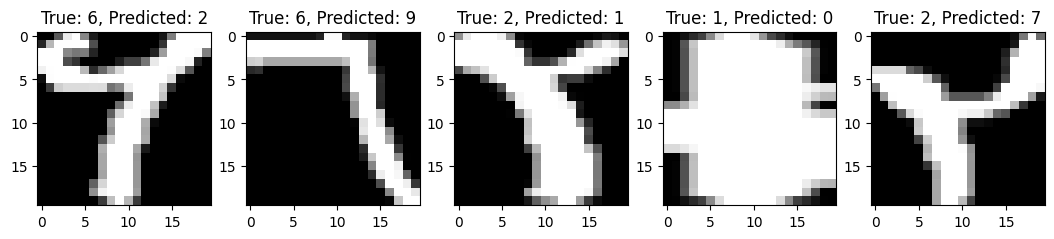

In [397]:
predictions = bnb.predict(
    test_data_binary.reshape(test_data_binary.shape[0], -1))

misclassified_indices = np.where(predictions != test_labels)[0][:5]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(13, 5))
for i, index in enumerate(misclassified_indices):
    img = test_data_resized[index]
    label = test_labels[index]
    predicted_label = predictions[index]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f'True: {label}, Predicted: {predicted_label}')
plt.show()
